In [19]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

Stationarity is an important assumption of timeseries analysis. A timeseries is characterized by stationarity when its parameters do not change overtime. Since many statistical tests require that data be stationary we will want to test of this property.

Below is a function for checking for stationarity: 

In [7]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False

Lets first just look at the btc volume data and determine whether or not it is indeed stationary

In [68]:
btc_trades = pd.read_csv('price_data/BTC.csv', parse_dates=True, index_col='time')
btc_trades.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,20.00,0.9902
2010-07-18,0.08584,0.08585,0.05941,0.04951,75.01,5.0900
2010-07-19,0.08080,0.09307,0.07723,0.08584,574.00,49.6600
2010-07-20,0.07474,0.08181,0.07426,0.08080,262.00,20.5900
2010-07-21,0.07921,0.07921,0.06634,0.07474,575.00,42.2600


p-value = 0.00100718951 The series volumefrom is likely stationary.


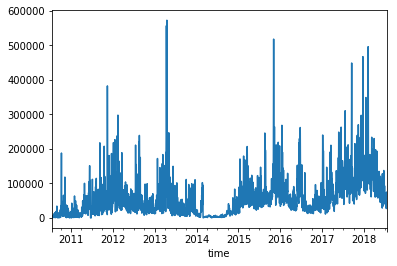

In [69]:
check_for_stationarity(btc_trades.volumefrom)
btc_trades.volumefrom.plot()

p-value = 0.132697082596 The series volumeto is likely non-stationary.


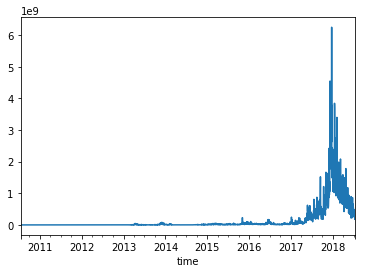

In [28]:
check_for_stationarity(btc_trades.volumeto)
btc_trades.volumeto.plot()

Volume data denominated in BTC is in fact stationary while volume data denominated in USD is not since the price of BTC is changing overtime. 

What about ether? 

p-value = 0.0177865584104 The series volumefrom is likely non-stationary.


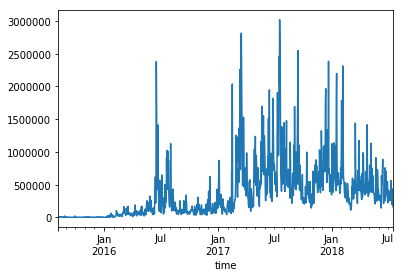

In [37]:
eth_trades = pd.read_csv('price_data/ETH.csv', parse_dates=True, index_col='time')
check_for_stationarity(eth_trades.volumefrom)
eth_trades.volumefrom.plot()

Interestingly ETH volume is not stationary over all observations. This is largely do to the fact that volume in 2015 and earlly 2016 is miniscule in comparison to the trading volume that occurs in 2017 and 2018.

In [40]:
check_for_stationarity(eth_trades[datetime(2016,3,1):].volumefrom)

p-value = 0.00367254105222 The series volumefrom is likely stationary.


True

When calculating the p value to test for stationarity of the data after May of 2016 we find that the data is likely stationary.

A cyclic movement of the mean will be very difficult to tell apart from random noise. In practice on noisy data and limited sample size it can be hard to determine if a series is stationary and whether any drift is random noise or part of a trend. In each individual case the test may or may not pick up subtle effects like this. 

With both BTC and ETH volume it seems that there is an upward trend and even a cyclcial shift of the mean. We'll look to the moving average representation and the order of integration to give us a better idea of whether or not they are stationary. 

An important concept in time series analysis is moving average representation. 

This representation expresses any time series $Y_t$ as 

$$Y_t = \sum_{j=0}^\infty b_j \epsilon_{t-j} + \eta_t$$

* $\epsilon$ is the 'innovation' series
* $b_j$ are the moving average weights of the innovation series
* $\eta$ is a deterministic series

The key here is as follows. $\eta$ is deterministic. The innovation process is stochastic and there to simulate new information occuring over time. Specifically, $\epsilon_t = \hat Y_t - Y_t$ where $\hat Y_t$ is the in the optimal forecast of $Y_t$ using only information from time before $t$. In other words, the best prediction you can make at time $t-1$ cannot account for the randomness in $\epsilon$.

Each $b_j$ just says how much previous values of $\epsilon$ influence $Y_t$.

A time series is said to be $I(0)$ if the following condition holds in a moving average representation. In hand-wavy english, the autocorrelation of the series decays sufficiently quickly.

$$\sum_{k=0}^\infty |b_k|^2 < \infty$$

This property turns out to be true of all stationary series, but by itself is not enough for stationarity to hold. This means that stationarity implies $I(0)$, but $I(0)$ does not imply stationarity. For more on orders of integration, please see the following links.

Given two randomly generated timeseries, one that is stationary and one that is not we can get a better sense of what $I(0)$ looks like.


In [52]:
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

Series A, which is stationary:

p-value = 2.27814220116e-15 The series A is likely stationary.


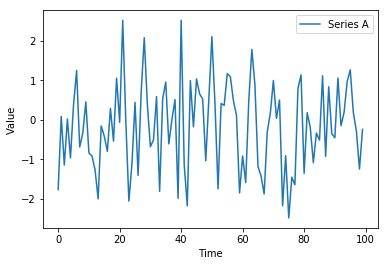

In [54]:
# Set the parameters and the number of datapoints
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    params = (0, 1)
    A[t] = generate_datapoint(params)

check_for_stationarity(A)
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A']);


Series B, which is not stationary:

p-value = 0.977301772877 The series B is likely non-stationary.


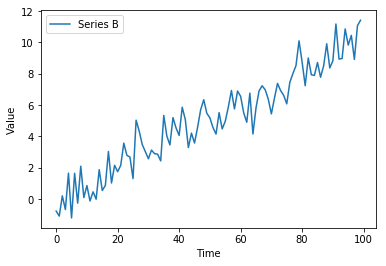

In [75]:
# Set the number of datapoints
T = 100

B = pd.Series(index=range(100))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_datapoint(params)

check_for_stationarity(B)
plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B']);

We can test whether or not the autocorrelation of the series decays sufficiently quickly by taking the cumsum of the series.

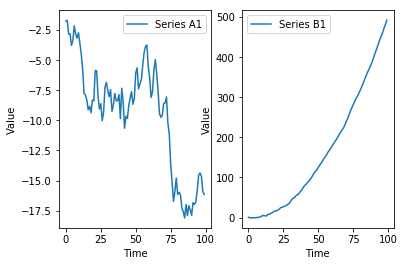

In [65]:
A1 = np.cumsum(A)
B1 = np.cumsum(B)

plt.subplot(1,2,1)
plt.plot(A1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A1'])

plt.subplot(1,2,2)
plt.plot(B1)
plt.xlabel('Time')
plt.ylabel('Value')

plt.legend(['Series B1'])
plt.show()

When looking at BTC and ETH their cumsums look much more like series B1 than A1, however they

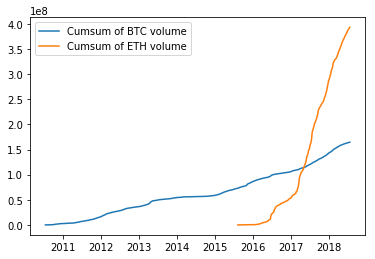

In [86]:
plt.plot(np.cumsum(btc_trades.volumefrom), label='Cumsum of BTC volume')
plt.plot(np.cumsum(eth_trades.volumefrom), label='Cumsum of ETH volume')
plt.legend()

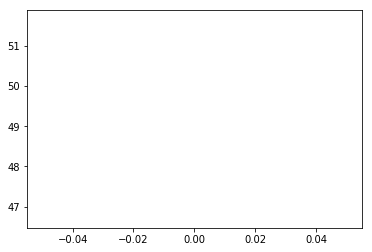

In [83]:
t = 100

mu = .5*t
sigma = 1
vol = np.random.normal(mu, sigma)
plt.plot(vol)

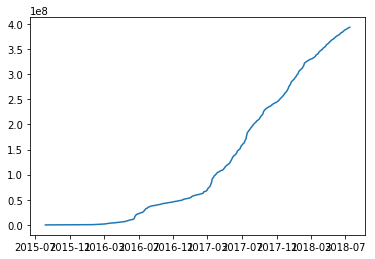

In [78]:
plt.plot(np.cumsum(eth_trades.volumefrom))
#plt.plot(A1, label='Series A1')

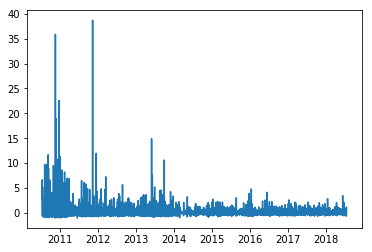

In [79]:
pct_change = btc_trades.volumefrom.pct_change()
plt.plot(pct_change)

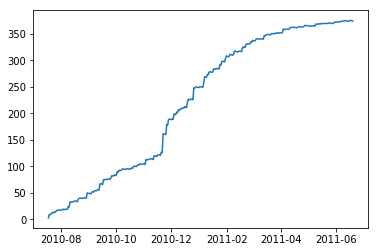

In [81]:
plt.plot(np.cumsum(pct_change))